In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import os
import sys
from time import strftime

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
# Use py3.9 kernel

Device: cpu


In [2]:
# Create a folder to store experiment results
timestamp = strftime("%Y-%m-%d_%H-%M")
# concatenates: e.g. results_2023-07-26_14-26
directory = "results_{}".format(timestamp)

# specify path
path = os.getcwd()

print(os.getcwd())
print(os.path)

if not os.path.exists(directory):
    os.makedirs(directory)

/Users/kimbente/NeuralProcesses
<module 'posixpath' from '/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/posixpath.py'>


## Load MNIST data

In [3]:
from datasets import mnist
from torchvision import datasets, transforms
from torchvision.utils import make_grid

mnist_batch_size = 8
mnist_size = 28

# 28 x 28 is the default size
# using mnist function written in datasets.py
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
train_loader, test_loader = mnist(batch_size = mnist_batch_size, size = mnist_size)

/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <67CD63CE-57E0-341F-B3B8-78729B03D2B3> /Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <18497461-1393-3DF8-BED0-DC986FDB1051> /Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Visualise 

torch.Size([28, 28])
tensor(9)


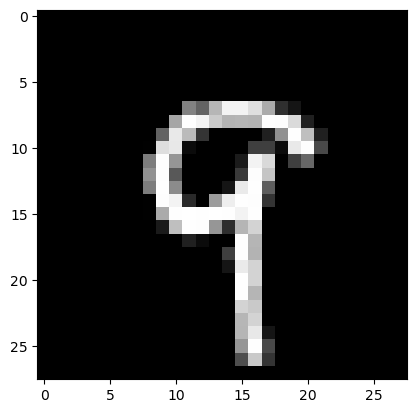

In [4]:
# show single image from test

for _, data in enumerate(train_loader):
    # unpack data
    images, labels = data
    # select single image and reshape to remove dimensions of cardinality 1ß
    # images has shape (mnist_batch_size, 1, 28, 28)
    image = images[1, :, :, :].squeeze()
    print(image.shape)
    print(labels[1])
    break

plt.imshow(image.numpy(), cmap = 'gray')


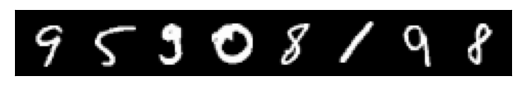

In [5]:
# show batch of test iamges
for _, data in enumerate(train_loader):
    # unpack data
    images, labels = data
    # only extract one batch and break
    break

import torchvision.transforms.functional as F

# show function
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols = len(imgs), squeeze = False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

# images: 4D mini-batch Tensor of shape (B x C x H x W)
image_grid = make_grid(images) 
show(image_grid)

## Explore masking

In [6]:
from utils import mask_to_np_input

# Create byte tensor 
# Assuming square shape, sampling from uniform distribution > True/False > imutable bytes()
mask_tensor = (torch.rand((mnist_size, mnist_size)) > 0.8).byte()
# Creates 8 copies
mask_tensor = torch.tile(mask_tensor, dims = (8, 1, 1))
# mask_tensor[1].view(-1).sum()
x, y = mask_to_np_input(img = images, mask = mask_tensor)
# x has shape (mnist_batch_size, num of unmasked pixels, normalised_x_location, normalised_y_location)
# y has shape (mnist_batch_size, num of unmasked pixels, normalised_value)

/Users/kimbente/NeuralProcesses/utils.py:90: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/aten/src/ATen/native/IndexingUtils.h:28.)
  y = img[mask_img_size].view(batch_size, num_channels, num_points)


In [7]:
upperhalf_mask_tensor = torch.zeros((28, 28)).byte()
upperhalf_mask_tensor[:14, :] = 1 # Top half of pixels are visible (rows 0:14, all columns)

# View occluded image

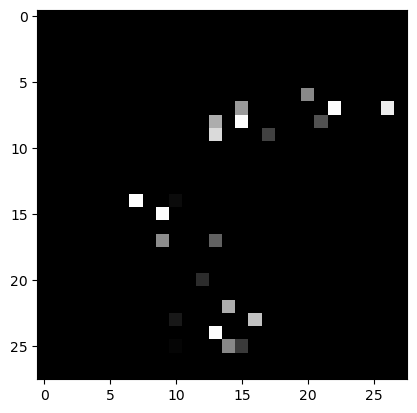

In [8]:
# Visualize occluded image
occluded_img = images[1] * mask_tensor[1].float()

# print(occluded_img.shape)
# Put first, explicit dimension last
# print(occluded_img.permute(1, 2, 0).shape)

plt.imshow(occluded_img.permute(1, 2, 0).numpy(), cmap = 'gray')

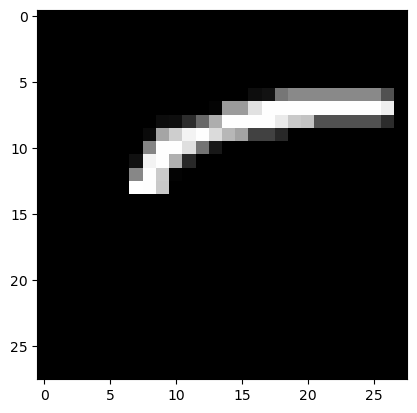

In [13]:
# Visualize occluded image
half_occluded_img = images[1] * upperhalf_mask_tensor.float()
plt.imshow(half_occluded_img.permute(1, 2, 0).numpy(), cmap = 'gray')

## Train Model

In [35]:
from datasets import mnist
from neuralprocess import NeuralProcess2D
from training import NeuralProcessTrainer

# Set hypers
# May also put this is an config file
img_size = [1, 28, 28]
batch_size = 16
r_dim = 256
h_dim = 256
z_dim = 256
num_context_range = [3, 200]
num_extra_target_range = [0, 200]
lr = 4e-5
epochs = 1

In [33]:
# Returns training loader and test loader
mnist_data_loader, _ = mnist(batch_size = batch_size, size = img_size[2])

np_img = NeuralProcess2D(img_size, r_dim, z_dim, h_dim).to(device)

optimizer = torch.optim.Adam(np_img.parameters(), lr = lr)

np_trainer = NeuralProcessTrainer(device = device, neural_process = np_img, 
                                  optimizer = optimizer, num_context_range = num_context_range, 
                                  num_extra_target_range = num_extra_target_range, print_freq = 100)

In [48]:
for epoch in range(epochs):
    print("Epoch {}".format(epoch + 1))
    np_trainer.train(mnist_data_loader, 1)
    # Save losses at every epoch
    with open(directory + '/losses.json', 'w') as f:
        json.dump(np_trainer.epoch_loss_history, f)
    # Save model at every epoch
    torch.save(np_trainer.neural_process.state_dict(), directory + '/model.pt')

Epoch 1
iteration 7800, loss -110.289
iteration 7900, loss -78.523
iteration 8000, loss -101.102
iteration 8100, loss -87.691
iteration 8200, loss -62.283
iteration 8300, loss -60.005
iteration 8400, loss -113.319
iteration 8500, loss -50.010
iteration 8600, loss -129.047
iteration 8700, loss -47.658
iteration 8800, loss -193.765
iteration 8900, loss -59.608
iteration 9000, loss -63.506
iteration 9100, loss -85.724
iteration 9200, loss -129.824
iteration 9300, loss -65.256
iteration 9400, loss -35.716
iteration 9500, loss -36.502
iteration 9600, loss -43.474
iteration 9700, loss -29.252
iteration 9800, loss -84.579
iteration 9900, loss -76.077
iteration 10000, loss -99.571
iteration 10100, loss -139.386
iteration 10200, loss -168.492
iteration 10300, loss -77.258
iteration 10400, loss -95.784
iteration 10500, loss -128.278
iteration 10600, loss -14.655
iteration 10700, loss -141.772
iteration 10800, loss -135.730
iteration 10900, loss -87.138
iteration 11000, loss -34.838
iteration 111

## Load the trained model

In [38]:
# Replace with latest
model_file = 'results_2023-07-27_14-35/model.pt'

# Re-initialise new model
trained_model = NeuralProcess2D(img_size, r_dim, z_dim, h_dim).to(device)

# Load from file
trained_model.load_state_dict(torch.load(model_file, map_location = lambda storage, loc: storage))

trained_model
# np_trainer.neural_process.state_dict()

NeuralProcess2D(
  (neural_process): NeuralProcess(
    (xy_to_r): rEncoder(
      (input_to_hidden): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (r_to_mu_sigma): zEncoder(
      (r_to_hidden): Linear(in_features=256, out_features=256, bias=True)
      (hidden_to_mu): Linear(in_features=256, out_features=256, bias=True)
      (hidden_to_sigma): Linear(in_features=256, out_features=256, bias=True)
    )
    (xz_to_y): Decoder(
      (xz_to_hidden): Sequential(
        (0): Linear(in_features=258, out_features=256, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): ReLU(inplace=Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


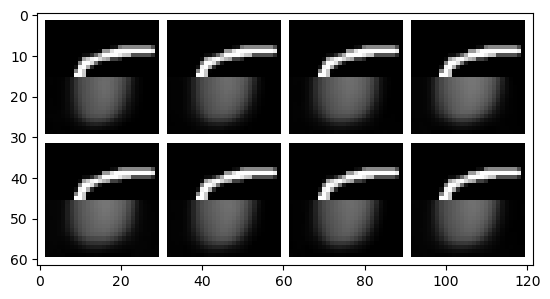

In [47]:
from utils import inpaint

# Number of inpaintings to sample from model
num_inpaintings = 8 
# Zero-filled frames
all_inpaintings = torch.zeros(num_inpaintings, 1, 28, 28)

# Sample several inpaintings
for i in range(num_inpaintings):
    # images is [8, 1, 28, 28] and mask tensor is also [8, 28, 28] (same mask across all channels)
    # all_inpaintings[i] = inpaint(trained_model, images[1], mask_tensor[1], device)
    all_inpaintings[i] = inpaint(trained_model, images[1], upperhalf_mask_tensor, device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow = 4, pad_value = 1.)
plt.imshow(inpainting_grid.permute(1, 2, 0).numpy())